In [1]:
!pip install loguru opencv-python-headless scipy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://bytedpypi.byted.org/simple/


In [2]:
import os
import torch
import cv2
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from scipy.spatial.transform import Rotation

import sys
sys.path.append('..')
from vlm3d.utils.box3d_utils import extract_bbox3d_from_json
from vlm3d.utils.vis_utils import get_cuboid_verts_faces, draw_3d_box_from_verts


/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
2025-11-11 19:35:41.660892: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 19:35:41.698137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-11 19:35:41.698186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when 

In [3]:
prompt_3dod = """
Here are the detailed camera parameters for the image.
Camera intrinsic parameters: Horizontal fov, hfov={hfov:.2f}, and vertical fov, vfov={vfov:.2f}. Image width={image_width} and height={image_height}. We do not consider distortion parameters here. 
Camera coordinate: X-axis points rightward, Y-axis points downward, and Z-axis points forward. The origin point is the camera location.
We take the camera coordinate system as the world coordinate system.

3D bounding box format: [x_center, y_center, z_center, x_size, y_size, z_size, pitch, yaw, roll]
* x_center, y_center, z_center: the center of the object in the camera coordinate, in meters. z_center is the depth of the object in space.
* x_size, y_size, z_size: The dimensions of the object along the ( XYZ ) axes, in meters, when the rotation angles are zero.
* pitch, yaw, roll: Euler angles representing rotations around the X, Y, and Z axes, respectively. Each angle is normalized to the range of (-1, 1) and is multiplied by 180 to convert it into degrees.

Output a json list where each entry contains the object name in "label" and its 3D bounding box in "bbox_3d"
{question}
""".strip()


def estimate_intrinsics(image_width, image_height, fov_degrees=90):
    f = image_width / (2 * np.tan(np.radians(fov_degrees)/2))
    intrinsics = [
        [f, 0, image_width/2],
        [0, f, image_height/2],
        [0, 0, 1]
    ]
    return intrinsics


def load_image(image_path):
    if image_path.startswith('http'):
        image_pil = Image.open(BytesIO(requests.get(image_path).content))
    elif os.path.exists(image_path):
        image_pil = Image.open(image_path)
    else:
        raise NotImplementedError()
    return image_pil


def print_convs(qwen_messages):
    for mes in qwen_messages:
        print(f"### {mes['role']}")
        for cont in mes['content']:
            if cont['type'] == 'text':
                print(cont['text'])

In [ ]:
model_path="rayruiyang/VST-7B-RL"
# model_path = "your_local_path/VST-7B-RL"

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

# default processer
processor = AutoProcessor.from_pretrained(model_path, min_pixels = 256*28*28, max_pixels=1280*28*28)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

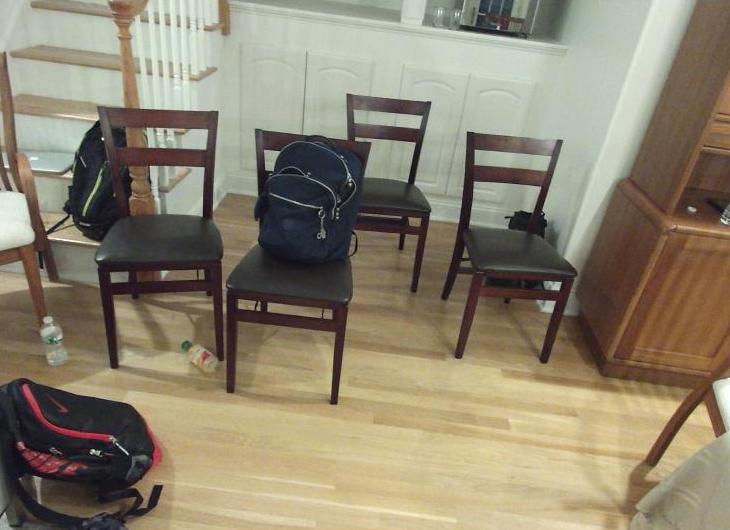

### user
Here are the detailed camera parameters for the image.
Camera intrinsic parameters: Horizontal fov, hfov=60.00, and vertical fov, vfov=60.00. Image width=730 and height=530. We do not consider distortion parameters here. 
Camera coordinate: X-axis points rightward, Y-axis points downward, and Z-axis points forward. The origin point is the camera location.
We take the camera coordinate system as the world coordinate system.

3D bounding box format: [x_center, y_center, z_center, x_size, y_size, z_size, pitch, yaw, roll]
* x_center, y_center, z_center: the center of the object in the camera coordinate, in meters. z_center is the depth of the object in space.
* x_size, y_size, z_size: The dimensions of the object along the ( XYZ ) axes, in meters, when the rotation angles are zero.
* pitch, yaw, roll: Euler angles representing rotations around the X, Y, and Z axes, respectively. Each angle is normalized to the range of (-1, 1) and is multiplied by 180 to convert it into degrees.


In [6]:
# prepare qwen messages
image = "demo_image.jpg"
question = "Detect the 3D bounding boxes of chair"
hfov, vfov = 60, 60 # default fov for general image, use correct intrinsics is better
image_pil = load_image(image)
image_width, image_height = image_pil.size
camera_intrinsics = estimate_intrinsics(image_width=image_width, image_height=image_height, fov_degrees=60)
# you can set the correct camera intrinsics
camera_intrinsics_correct = [[529.5, 0, 365.0], [0, 529.5, 265.0], [0, 0, 1]]

prompt = prompt_3dod.format(question=question, hfov=hfov, vfov=vfov, image_width=image_width, image_height=image_height)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image,},
            {"type": "text", "text": prompt},
        ],
    }
]

image_pil.show()
print_convs(messages)

In [7]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=2048)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print("### VST")
print(output_text[0])

### VST
```json
[
	{"bbox_3d":[-0.29,-0.04,2.23,0.61,0.94,0.47,0.4,0.33,0.43],"label":"chair"},
	{"bbox_3d":[-0.77,-0.16,2.24,0.62,0.96,0.51,0.36,0.32,0.38],"label":"chair"},
	{"bbox_3d":[-1.47,-0.28,2.25,0.62,0.97,0.58,0.27,0.28,0.28],"label":"chair"},
	{"bbox_3d":[0.61,-0.1,2.58,0.6,0.85,0.48,0.33,0.31,0.35],"label":"chair"},
	{"bbox_3d":[0.06,-0.37,2.91,0.63,0.85,0.52,0.33,0.31,0.35],"label":"chair"}
]
```


# visualize with the correct camera intrinsics

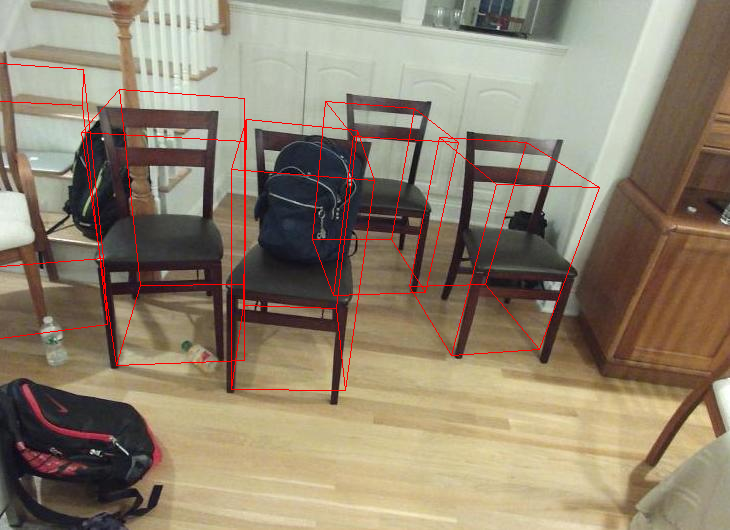

In [8]:
bboxes3d = extract_bbox3d_from_json(output_text[0], from_range='1', to_range='180')

image_cv2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
for bbox3d in bboxes3d:
    R_bbox2cam = Rotation.from_euler(angles=bbox3d[-3:], seq='xyz', degrees=True).as_matrix()
    verts3d, _ = get_cuboid_verts_faces(box3d=bbox3d[:6], R=R_bbox2cam)
    draw_3d_box_from_verts(im=image_cv2, K=camera_intrinsics_correct, verts3d=verts3d, color=(0, 0, 255))

image_w_box = Image.fromarray(image_cv2[:, :, ::-1])
image_w_box.show()

# visualize with the estimated camera intrinsics

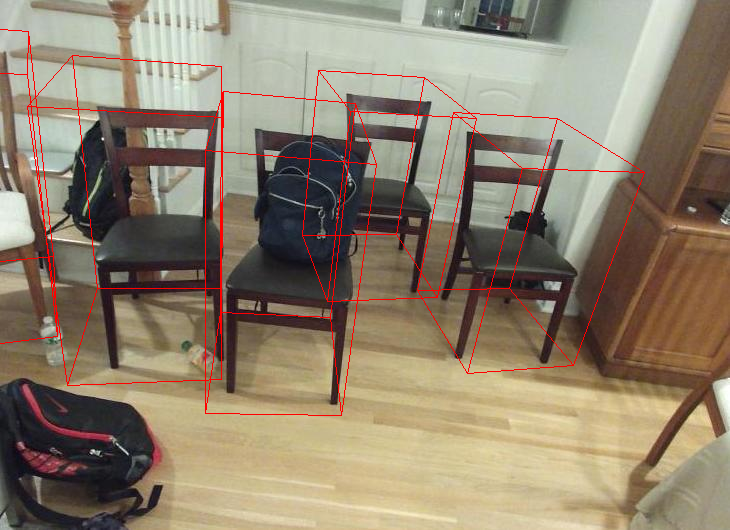

In [9]:
bboxes3d = extract_bbox3d_from_json(output_text[0], from_range='1', to_range='180')

image_cv2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
for bbox3d in bboxes3d:
    R_bbox2cam = Rotation.from_euler(angles=bbox3d[-3:], seq='xyz', degrees=True).as_matrix()
    verts3d, _ = get_cuboid_verts_faces(box3d=bbox3d[:6], R=R_bbox2cam)
    draw_3d_box_from_verts(im=image_cv2, K=camera_intrinsics, verts3d=verts3d, color=(0, 0, 255))

image_w_box = Image.fromarray(image_cv2[:, :, ::-1])
image_w_box.show()